In [1]:
import sys
sys.path.append('/home/esp/data_analyze/05.02.2025/code')

import pandas as pd
import microbiome_analysis as ma
import microbiome_subgroup_analysis as msa

import warnings
warnings.filterwarnings('ignore')


# Настройка путей и переменных
MAIN_DIR = '05.02.2025'
PART_OF_PATH = 'only_genus_subgroup'
GROUP_LIST = ['OB-BPD/DS ', 'CHJ-BPD/DS+', 'CHJ-BPD/DS-', 'CN/SD ']
SUPGROUP_LIST = ['MAM-J', 'MAM-I', 'MAMLI', 'MAM-D', 'Fecal']

DF = pd.read_csv(
    f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/out_data/{PART_OF_PATH}_out.csv',
    sep='\t',
    index_col=[0]
)

PATH_TO_ALPHA_OUTPUT_DATA = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/alpha/data'
PATH_TO_ALPHA_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/alpha/figure'
PATH_TO_BETA_OUTPUT_DATA = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/beta/data'
PATH_TO_BETA_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/beta/figure'
PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_DATA = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/relative_abundance/data'
PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/relative_abundance/figure'
PATH_TO_VENN_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/venn/figure'
PATH_TO_FB_OUTPUT_DATA = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/fb/data'
PATH_TO_FB_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/fb/figure'

SAFE_DATA = False
SHOW = True

#groups = DF['GROUP'].unique()
PALETTE = {GROUP_LIST[0]: '#1924B1', GROUP_LIST[1]: '#74E600', GROUP_LIST[2]:'#7200e6', GROUP_LIST[3]:'#b1a619'}
ma.PALETTE = PALETTE
ma.GROUP_LIST = GROUP_LIST

ma.PATH_TO_ALPHA_OUTPUT_DATA = PATH_TO_ALPHA_OUTPUT_DATA
ma.PATH_TO_ALPHA_OUTPUT_FIGURE = PATH_TO_ALPHA_OUTPUT_FIGURE
ma.PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_DATA  = PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_DATA
ma.PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_FIGURE = PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_FIGURE
ma.PATH_TO_VENN_OUTPUT_FIGURE = PATH_TO_VENN_OUTPUT_FIGURE
ma.PATH_TO_BETA_OUTPUT_DATA = PATH_TO_BETA_OUTPUT_DATA
ma.PATH_TO_BETA_OUTPUT_FIGURE = PATH_TO_BETA_OUTPUT_FIGURE
ma.PATH_TO_FB_OUTPUT_FIGURE = PATH_TO_FB_OUTPUT_FIGURE
ma.PATH_TO_FB_OUTPUT_DATA = PATH_TO_FB_OUTPUT_DATA
ma.SHOW = SHOW
ma.SAFE_DATA = SAFE_DATA


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
import itertools

def filter_taxa_by_prevalence(df, 
                              abundance_col='RelativeAbundance', 
                              sample_col='#SampleID', 
                              taxonomy_col='Taxonomy',
                              presence_threshold=0.01, 
                              min_samples_fraction=0.1):
    n_samples = df[sample_col].nunique()
    presence_counts = (
        df[df[abundance_col] >= presence_threshold]
        .groupby(taxonomy_col)[sample_col]
        .nunique()
    )
    min_count = int(np.ceil(n_samples * min_samples_fraction))
    prevalent_taxa = presence_counts[presence_counts >= min_count].index
    filtered_df = df[df[taxonomy_col].isin(prevalent_taxa)].copy()
    return filtered_df

def remove_outliers_iqr(df, group_col, value_col, factor=1.5):
    filtered_list = []
    outliers_list = []
    
    for g, sub_df in df.groupby(group_col):
        Q1 = sub_df[value_col].quantile(0.25)
        Q3 = sub_df[value_col].quantile(0.75)
        iqr = Q3 - Q1
        lower = Q1 - factor * iqr
        upper = Q3 + factor * iqr
        
        mask = sub_df[value_col].between(lower, upper)
        filtered_list.append(sub_df[mask])
        outliers_list.append(sub_df[~mask])
    
    return pd.concat(filtered_list), pd.concat(outliers_list)

def test_taxa_kruskal_fdr(df, group_col='GROUP', value_col='RelativeAbundance', taxonomy_col='Taxonomy'):
    results = []
    unique_taxa = df[taxonomy_col].unique()

    for taxon in unique_taxa:
        df_taxon = df[df[taxonomy_col] == taxon]
        grouped_data = [
            df_taxon.loc[df_taxon[group_col] == g, value_col].dropna().values
            for g in df[group_col].unique()
        ]
        if all(len(arr) > 0 for arr in grouped_data):
            stat, p_val = kruskal(*grouped_data)
            results.append((taxon, p_val))

    if len(results) > 0:
        taxa, pvals = zip(*results)
        pvals_corrected = multipletests(pvals, alpha=0.05, method='fdr_bh')[1]
        results_df = pd.DataFrame({
            taxonomy_col: taxa,
            'p_value_raw': pvals,
            'p_value_fdr': pvals_corrected
        })
        return results_df.sort_values('p_value_fdr')
    else:
        return pd.DataFrame(columns=[taxonomy_col, 'p_value_raw', 'p_value_fdr'])



df_filtered = filter_taxa_by_prevalence(DF, 
                                        presence_threshold=0.01, 
                                        min_samples_fraction=0.1)


results_kruskal = test_taxa_kruskal_fdr(df_filtered, 'GROUP', 'RelativeAbundance', 'Taxonomy')
df_filtered.shape

(5719, 7)

In [3]:
df_filtered["Taxonomy"] = "k_" + df_filtered["Taxonomy"]

df_filtered.head()

#SampleID                                           Taxonomy       GROUP  \
58        10A  k_Bacteria|p_Actinobacteriota|c_Actinobacteria...  OB-BPD/DS    
142       10A                          k_Bacteria|p_Bacteroidota  OB-BPD/DS    
143       10A            k_Bacteria|p_Bacteroidota|c_Bacteroidia  OB-BPD/DS    
144       10A  k_Bacteria|p_Bacteroidota|c_Bacteroidia|o_Bact...  OB-BPD/DS    
146       10A  k_Bacteria|p_Bacteroidota|c_Bacteroidia|o_Bact...  OB-BPD/DS    

    Subgroup  Value  Total  RelativeAbundance  
58     MAM-J   1682  92085           0.018266  
142    MAM-J      4  92085           0.000043  
143    MAM-J      0  92085           0.000000  
144    MAM-J      8  92085           0.000087  
146    MAM-J      2  92085           0.000022

In [4]:
def filter_taxa_by_level(df, taxonomy_col='Taxonomy', level='genus'):
    """
    Фильтрует таксоны по заданному уровню (например, genus, family, species).

    Параметры:
    ----------
    df : pd.DataFrame
        DataFrame с колонкой, содержащей таксономию.
    taxonomy_col : str, optional
        Название колонки с таксономией (по умолчанию 'Taxonomy').
    level : str, optional
        Уровень таксономии, который нужно оставить. Допустимые значения:
        'phylum', 'class', 'order', 'family', 'genus', 'species'.
        По умолчанию 'genus'.

    Возвращает:
    -----------
    pd.DataFrame
        DataFrame с отфильтрованными таксонами.
    """
    level_prefixes = {
        'kingdom': 'k_',
        'phylum': 'p_',
        'class': 'c_',
        'order': 'o_',
        'family': 'f_',
        'genus': 'g_',
        'species': 's_'
    }

    if level not in level_prefixes:
        raise ValueError(f"Неподдерживаемый уровень таксономии: {level}. "
                         f"Допустимые значения: {list(level_prefixes.keys())}")

    prefix = level_prefixes[level]

    df_filtered = df.copy()
    
    # Оставляем только нужный уровень
    df_filtered[taxonomy_col] = df_filtered[taxonomy_col].apply(
        lambda x: '|'.join([part for part in x.split('|') if part.startswith(prefix)]) if isinstance(x, str) else x
    )
    
    # Удаляем строки, где после фильтрации `Taxonomy` пуст
    df_filtered = df_filtered[df_filtered[taxonomy_col] != '']

    # Удаление дубликатов (если они возникли после фильтрации)
    df_filtered = df_filtered.drop_duplicates(subset=['#SampleID', taxonomy_col])

    return df_filtered



In [5]:
df_filtered_genus = filter_taxa_by_level(df_filtered, taxonomy_col='Taxonomy', level='genus')
print(df_filtered_genus.shape)
df_filtered_genus.head()


(2926, 7)


#SampleID            Taxonomy       GROUP Subgroup  Value  Total  \
58        10A   g_Corynebacterium  OB-BPD/DS     MAM-J   1682  92085   
146       10A       g_Bacteroides  OB-BPD/DS     MAM-J      2  92085   
167       10A        g_Prevotella  OB-BPD/DS     MAM-J      0  92085   
177       10A  g_dgA-11 gut group  OB-BPD/DS     MAM-J      0  92085   
220       10A     g_Campylobacter  OB-BPD/DS     MAM-J     73  92085   

     RelativeAbundance  
58            0.018266  
146           0.000022  
167           0.000000  
177           0.000000  
220           0.000793


=== Analyzing Subgroup: MAM-J ===

=== SHANNON ANOVA ===
              sum_sq    df         F    PR(>F)
C(GROUP)   1.892094   3.0  1.317498  0.290847
Residual  11.967721  25.0       NaN       NaN
=== SHANNON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-    0.4475  0.5638 -0.4903  1.3854   False
1  CHJ-BPD/DS+       CN/SD    -0.1038  0.9900 -1.0417  0.8341   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.2979  0.8601 -1.3402  0.7445   False
3  CHJ-BPD/DS-       CN/SD    -0.5514  0.4577 -1.5686  0.4659   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.7454  0.2791 -1.8598  0.3690   False


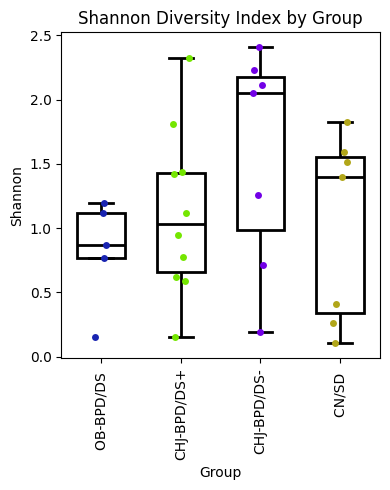


=== SIMPSON ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.269237   3.0  1.109544  0.363862
Residual  2.022128  25.0       NaN       NaN
=== SIMPSON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-    0.1541  0.6929 -0.2314  0.5397   False
1  CHJ-BPD/DS+       CN/SD    -0.0604  0.9726 -0.4459  0.3252   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.1245  0.8542 -0.5529  0.3040   False
3  CHJ-BPD/DS-       CN/SD    -0.2145  0.5045 -0.6327  0.2037   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.2786  0.3584 -0.7367  0.1795   False


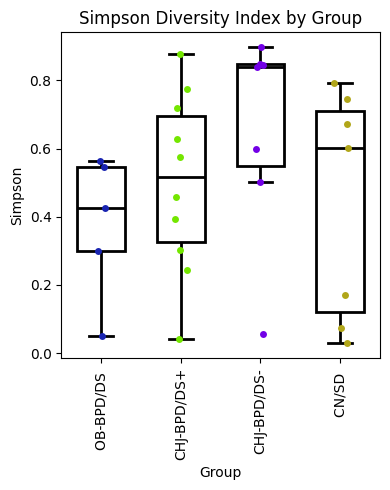


=== OBSERVED ANOVA ===
               sum_sq    df         F    PR(>F)
C(GROUP)  103.436946   3.0  5.403261  0.005257
Residual  159.528571  25.0       NaN       NaN
=== OBSERVED Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.2714  0.9962 -3.6956  3.1528   False
1  CHJ-BPD/DS+       CN/SD     0.8714  0.8961 -2.5528  4.2956   False
2  CHJ-BPD/DS+   OB-BPD/DS    -4.7000  0.0115 -8.5058 -0.8942    True
3  CHJ-BPD/DS-       CN/SD     1.1429  0.8318 -2.5712  4.8569   False
4  CHJ-BPD/DS-   OB-BPD/DS    -4.4286  0.0292 -8.4971 -0.3600    True


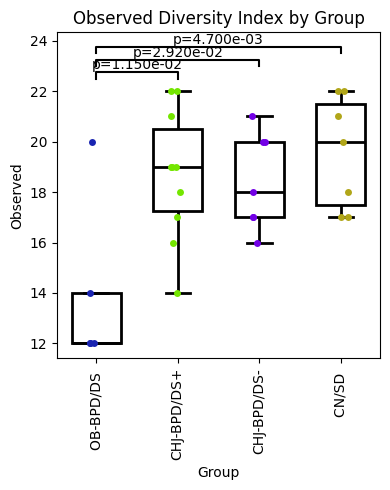


=== PIELOU_E ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.191732   3.0  1.147093  0.349473
Residual  1.392886  25.0       NaN       NaN
=== PIELOU_E Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-    0.1541  0.5565 -0.1659  0.4740   False
1  CHJ-BPD/DS+       CN/SD    -0.0385  0.9872 -0.3585  0.2815   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.0676  0.9528 -0.4232  0.2880   False
3  CHJ-BPD/DS-       CN/SD    -0.1926  0.4376 -0.5396  0.1545   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.2217  0.3947 -0.6018  0.1585   False


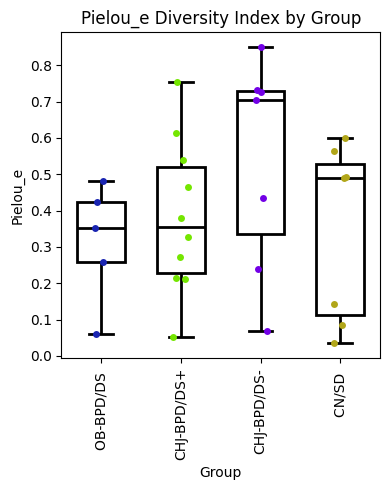

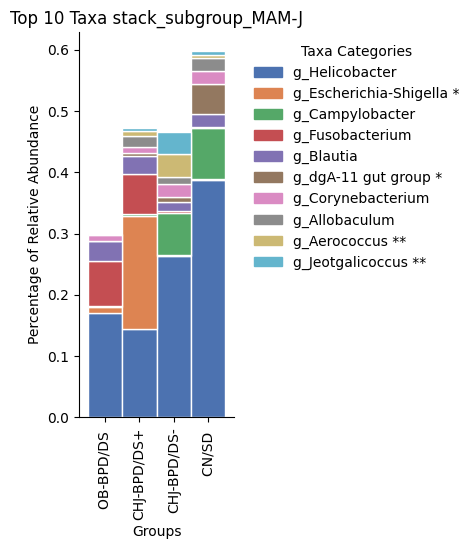

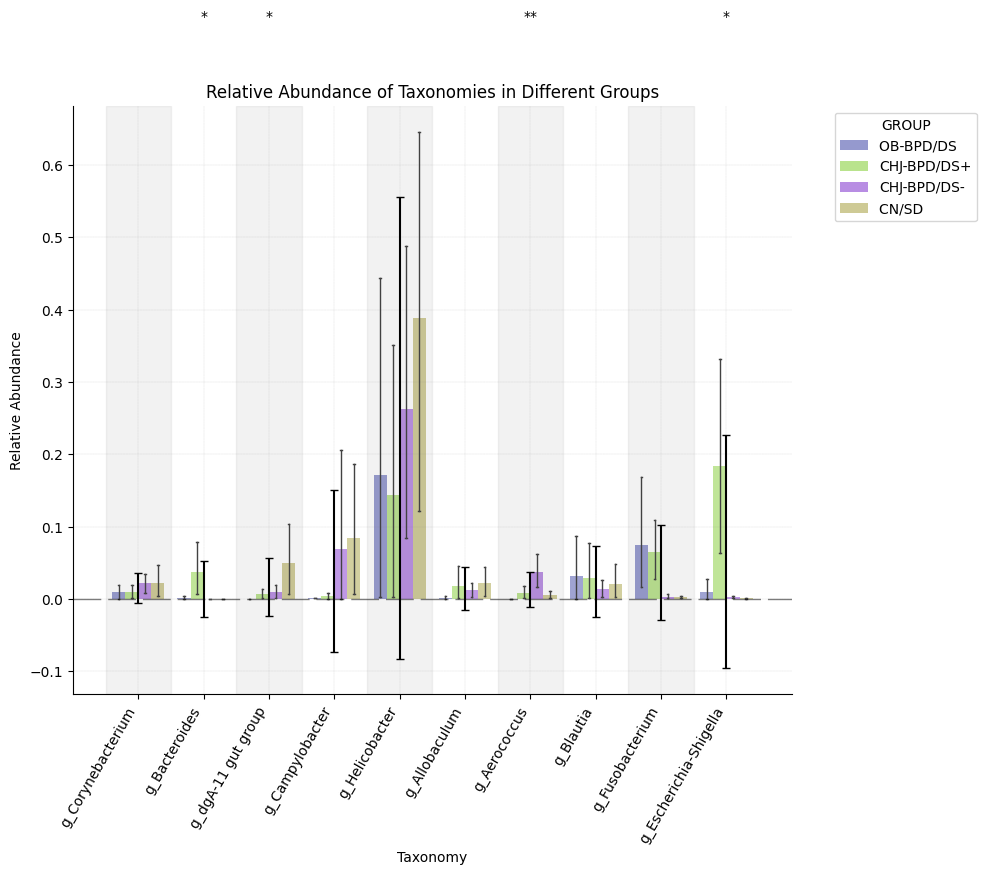

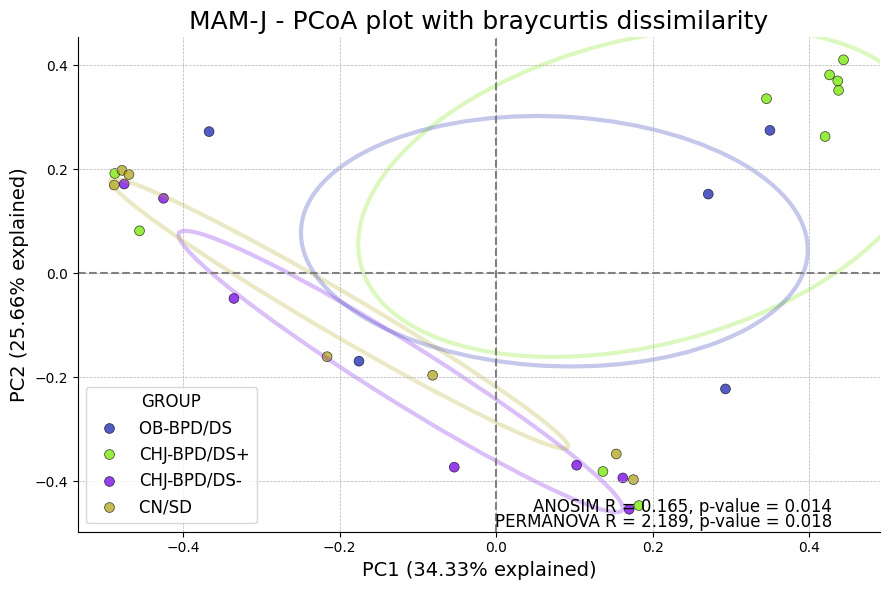

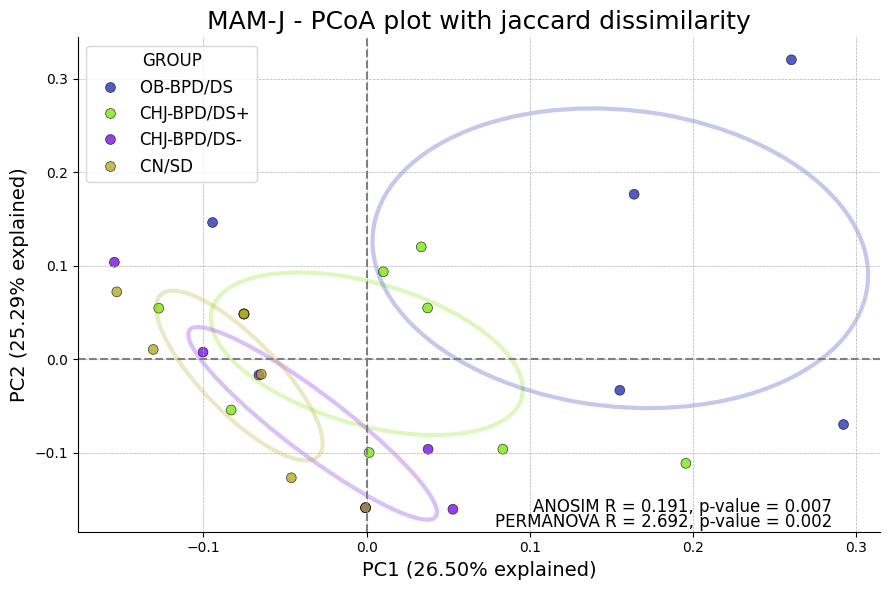

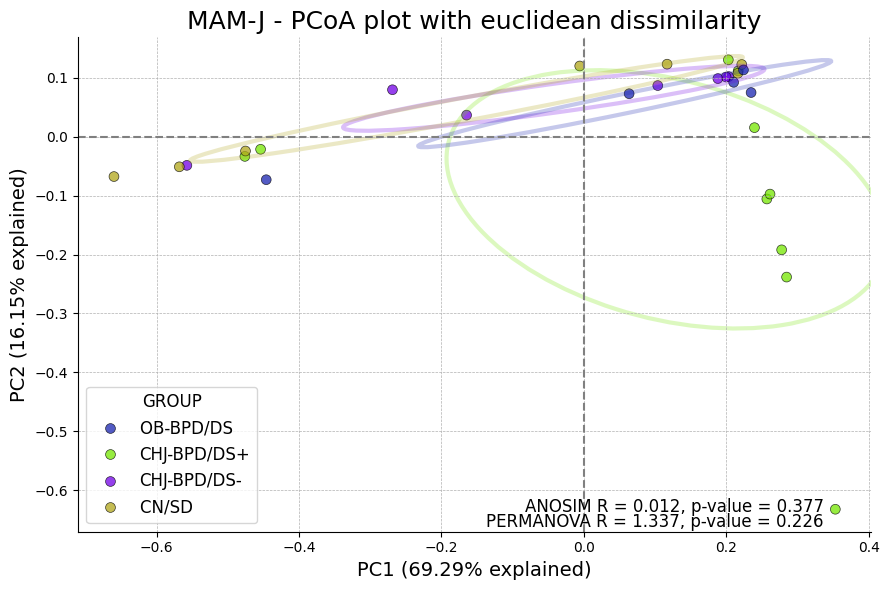

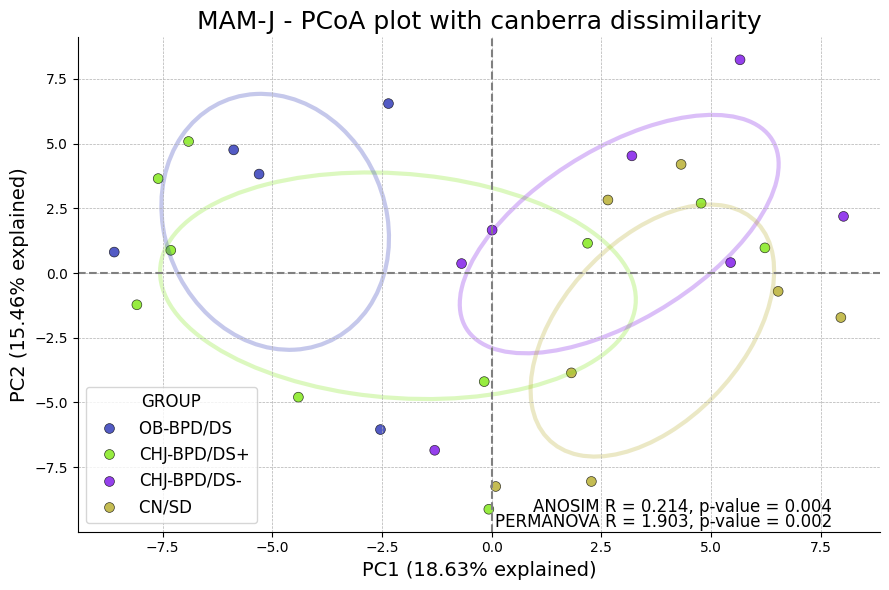

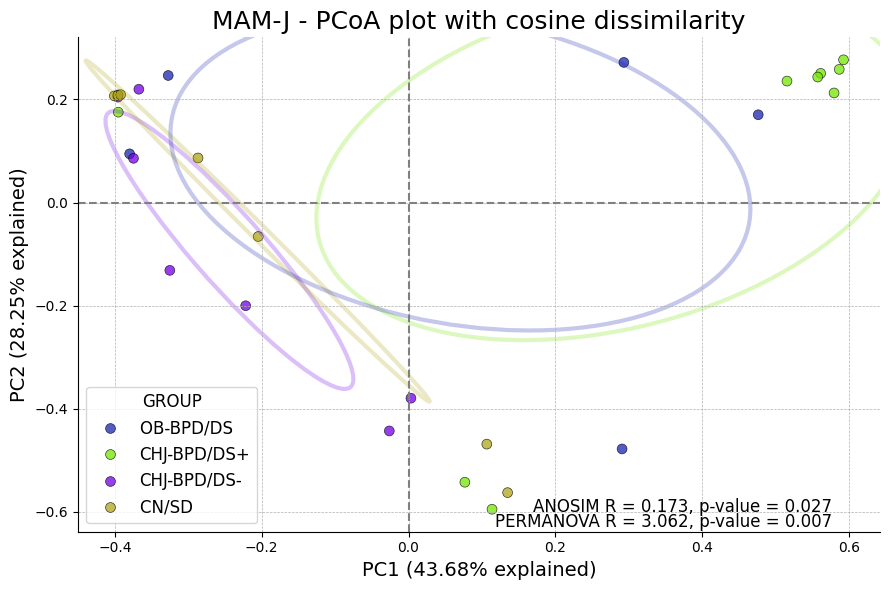


=== Analyzing Subgroup: MAM-I ===

=== SHANNON ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.827428   3.0  0.718536  0.551072
Residual  8.828527  23.0       NaN       NaN
=== SHANNON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.2784  0.8092 -1.1424  0.5857   False
1  CHJ-BPD/DS+       CN/SD     0.0291  0.9997 -0.8745  0.9327   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.4028  0.6538 -1.3591  0.5535   False
3  CHJ-BPD/DS-       CN/SD     0.3075  0.8090 -0.6464  1.2614   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.1245  0.9858 -1.1284  0.8795   False


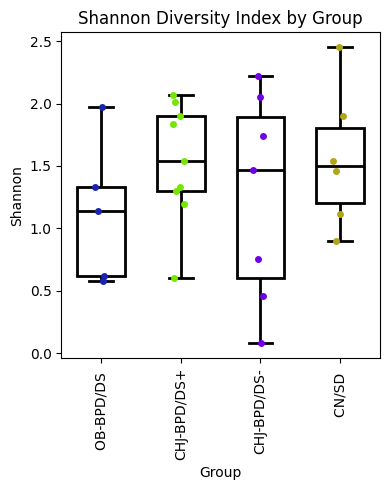


=== SIMPSON ANOVA ===
             sum_sq    df       F    PR(>F)
C(GROUP)  0.109858   3.0  0.7223  0.548945
Residual  1.166059  23.0     NaN       NaN
=== SIMPSON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.1064  0.7850 -0.4204  0.2076   False
1  CHJ-BPD/DS+       CN/SD     0.0288  0.9948 -0.2996  0.3572   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.1257  0.7505 -0.4732  0.2219   False
3  CHJ-BPD/DS-       CN/SD     0.1352  0.7051 -0.2114  0.4819   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.0192  0.9989 -0.3841  0.3456   False


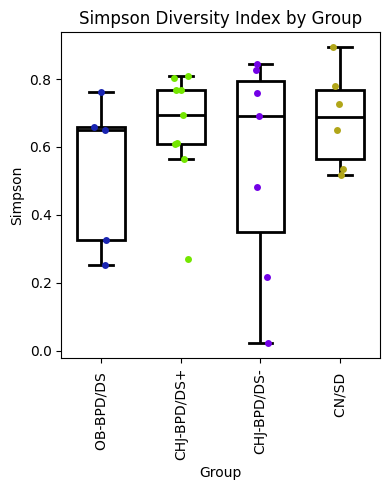


=== OBSERVED ANOVA ===
               sum_sq    df          F    PR(>F)
C(GROUP)  129.159788   3.0  10.124672  0.000192
Residual   97.803175  23.0        NaN       NaN
=== OBSERVED Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.4603  0.9703 -3.3361  2.4155   False
1  CHJ-BPD/DS+       CN/SD     1.1111  0.7383 -1.8965  4.1187   False
2  CHJ-BPD/DS+   OB-BPD/DS    -5.2889  0.0007 -8.4718 -2.1060    True
3  CHJ-BPD/DS-       CN/SD     1.5714  0.5301 -1.6034  4.7462   False
4  CHJ-BPD/DS-   OB-BPD/DS    -4.8286  0.0030 -8.1700 -1.4872    True


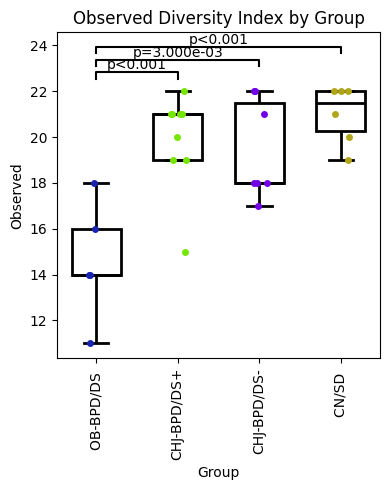


=== PIELOU_E ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.057242   3.0  0.464273  0.709993
Residual  0.945248  23.0       NaN       NaN
=== PIELOU_E Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.0900  0.8148 -0.3727  0.1928   False
1  CHJ-BPD/DS+       CN/SD     0.0036  1.0000 -0.2921  0.2993   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.0928  0.8439 -0.4058  0.2201   False
3  CHJ-BPD/DS-       CN/SD     0.0936  0.8399 -0.2185  0.4057   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.0029  1.0000 -0.3314  0.3256   False


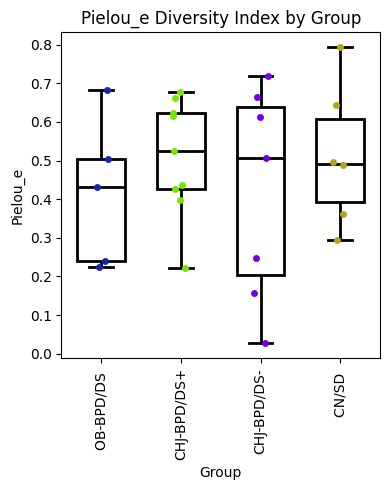

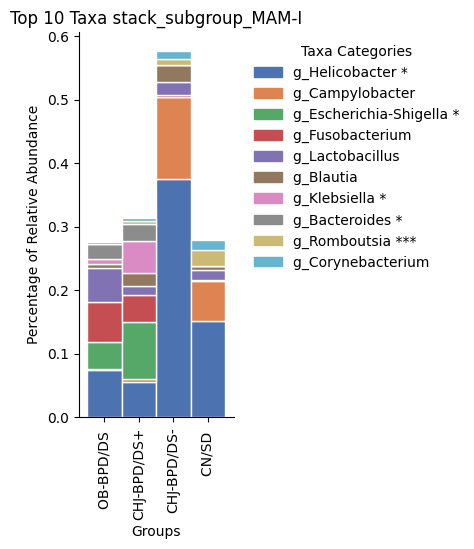

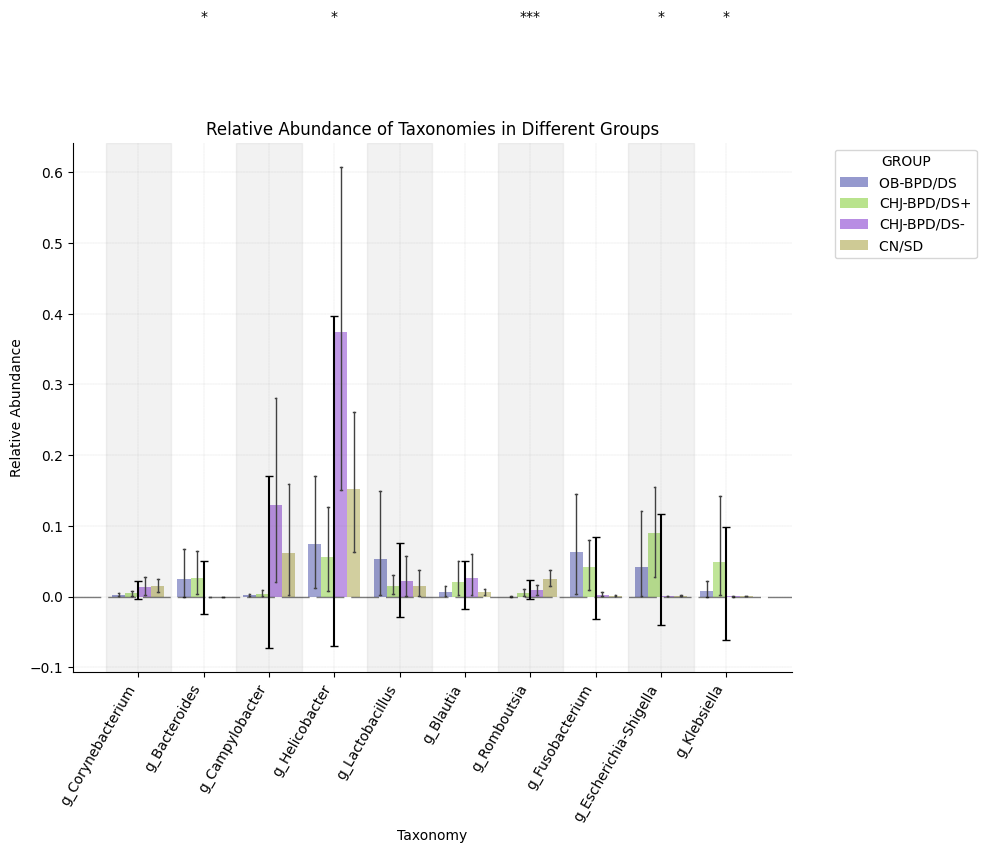

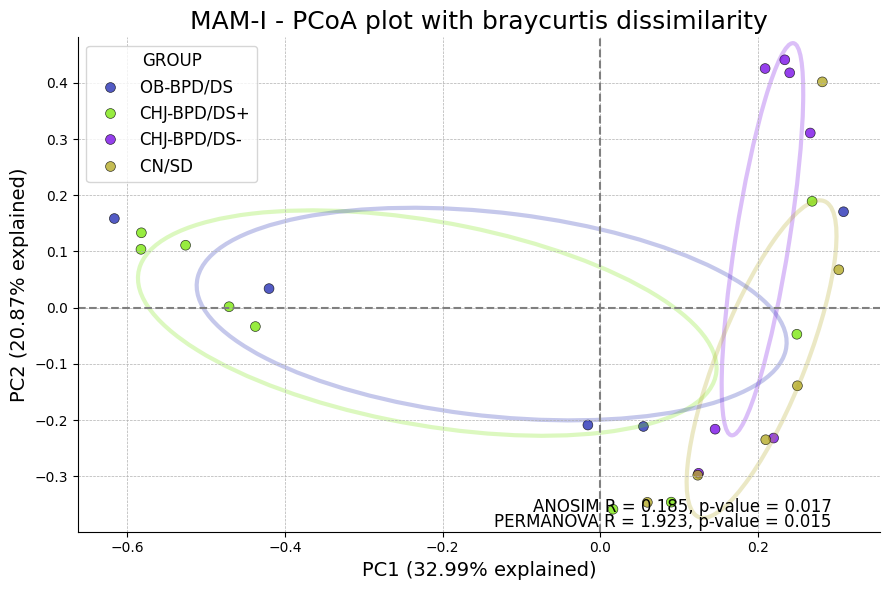

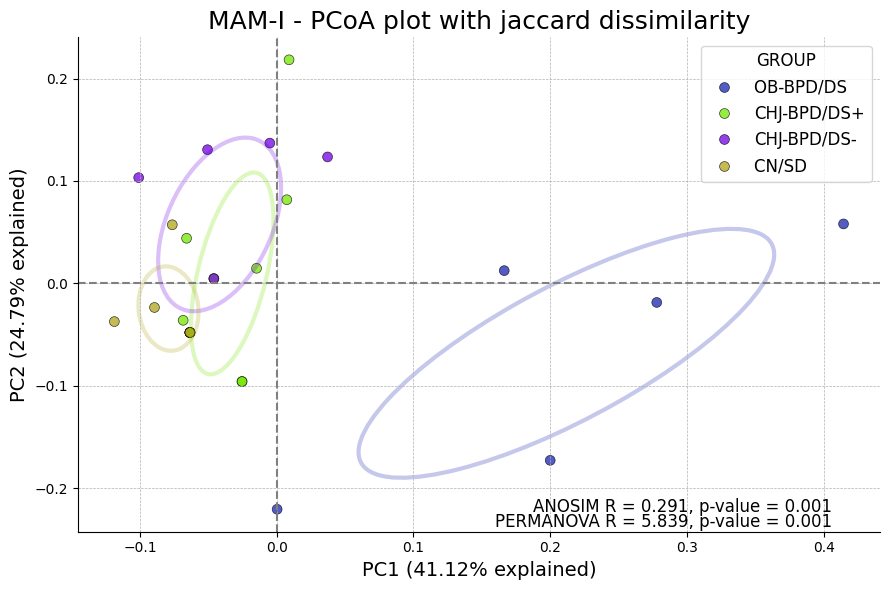

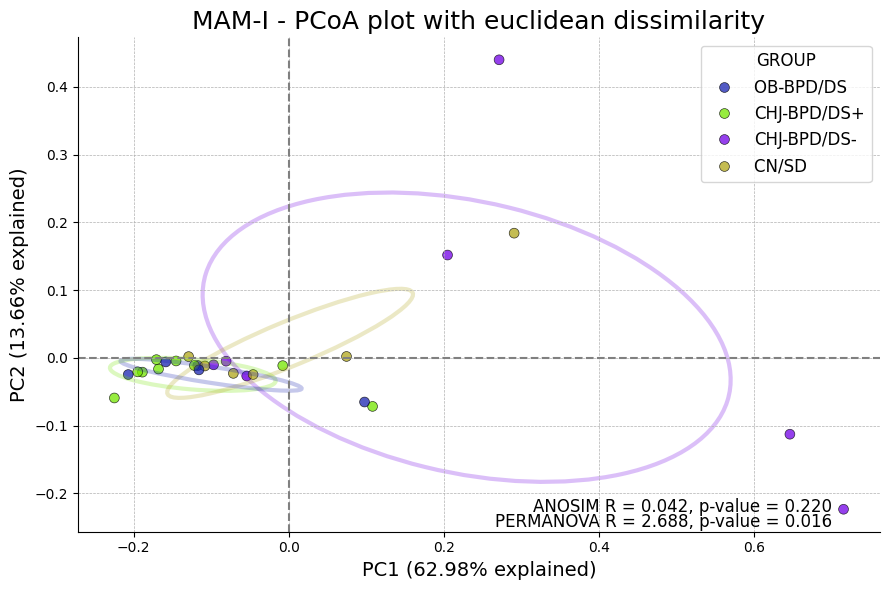

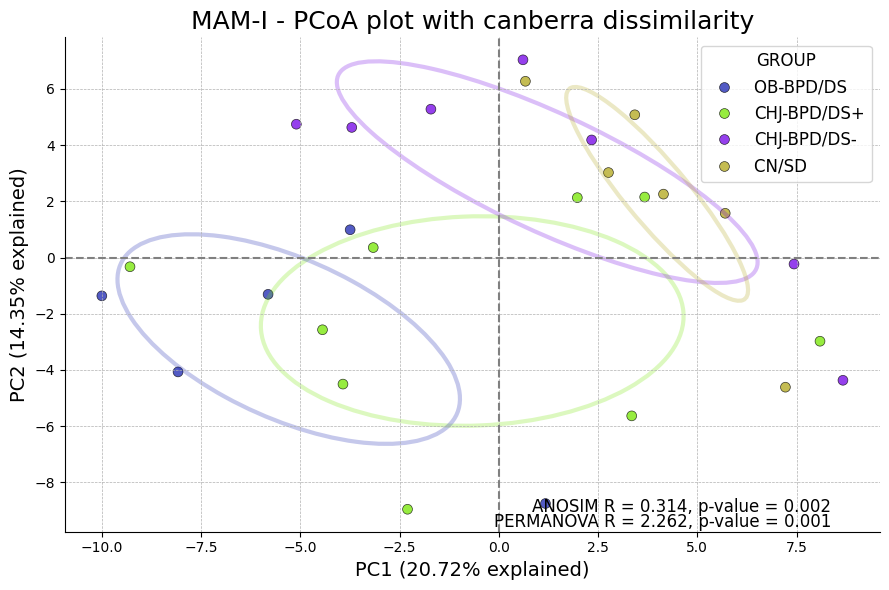

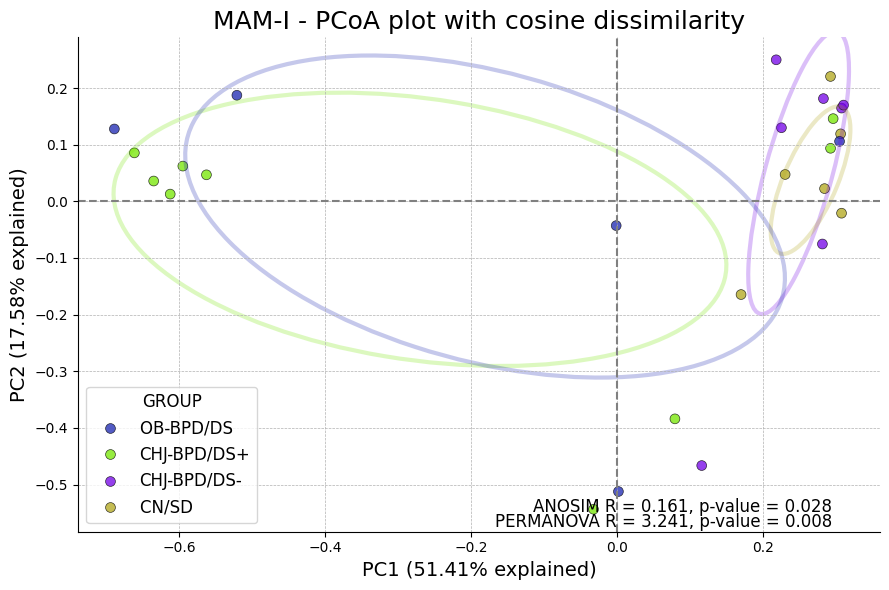


=== Analyzing Subgroup: MAMLI ===

=== SHANNON ANOVA ===
              sum_sq    df         F   PR(>F)
C(GROUP)   1.239501   3.0  0.630202  0.60264
Residual  15.734642  24.0       NaN      NaN
=== SHANNON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.3582  0.8268 -1.5116  0.7953   False
1  CHJ-BPD/DS+       CN/SD    -0.5007  0.5993 -1.6015  0.6000   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.4055  0.7974 -1.6289  0.8179   False
3  CHJ-BPD/DS-       CN/SD    -0.1425  0.9888 -1.3852  1.1002   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.0473  0.9997 -1.3999  1.3052   False


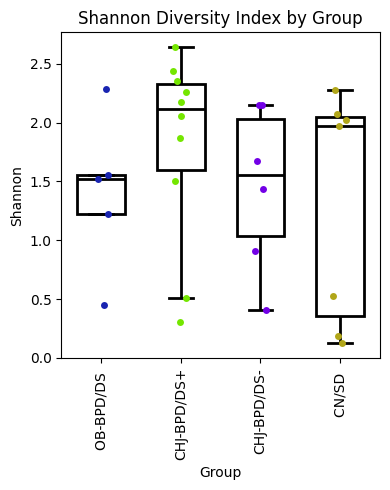


=== SIMPSON ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.148915   3.0  0.531829  0.664808
Residual  2.240044  24.0       NaN       NaN
=== SIMPSON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.1324  0.8354 -0.5676  0.3028   False
1  CHJ-BPD/DS+       CN/SD    -0.1802  0.6348 -0.5955  0.2352   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.0971  0.9370 -0.5588  0.3645   False
3  CHJ-BPD/DS-       CN/SD    -0.0478  0.9920 -0.5167  0.4211   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.0352  0.9975 -0.4751  0.5455   False


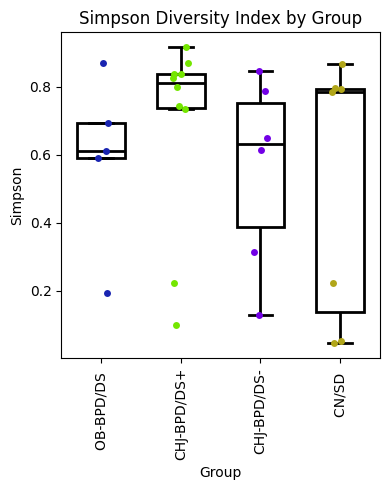


=== OBSERVED ANOVA ===
               sum_sq    df         F    PR(>F)
C(GROUP)   29.188095   3.0  2.021853  0.137657
Residual  115.490476  24.0       NaN       NaN
=== OBSERVED Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-    1.0333  0.7986 -2.0916  4.1583   False
1  CHJ-BPD/DS+       CN/SD     0.8429  0.8629 -2.1393  3.8250   False
2  CHJ-BPD/DS+   OB-BPD/DS    -1.9000  0.4076 -5.2145  1.4145   False
3  CHJ-BPD/DS-       CN/SD    -0.1905  0.9986 -3.5572  3.1762   False
4  CHJ-BPD/DS-   OB-BPD/DS    -2.9333  0.1496 -6.5977  0.7310   False


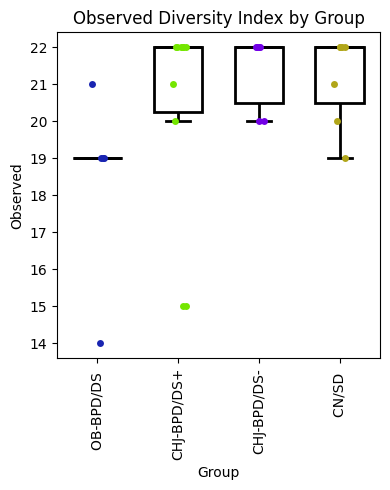


=== PIELOU_E ANOVA ===
             sum_sq    df         F   PR(>F)
C(GROUP)  0.128885   3.0  0.636402  0.59887
Residual  1.620175  24.0       NaN      NaN
=== PIELOU_E Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.1160  0.8227 -0.4862  0.2541   False
1  CHJ-BPD/DS+       CN/SD    -0.1661  0.5734 -0.5193  0.1871   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.1164  0.8454 -0.5090  0.2762   False
3  CHJ-BPD/DS-       CN/SD    -0.0501  0.9854 -0.4488  0.3487   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.0004  1.0000 -0.4344  0.4336   False


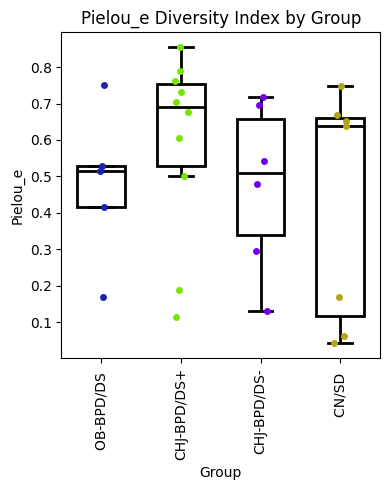

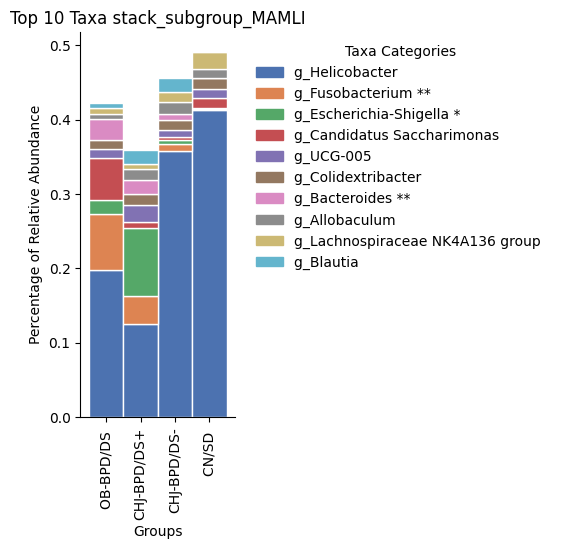

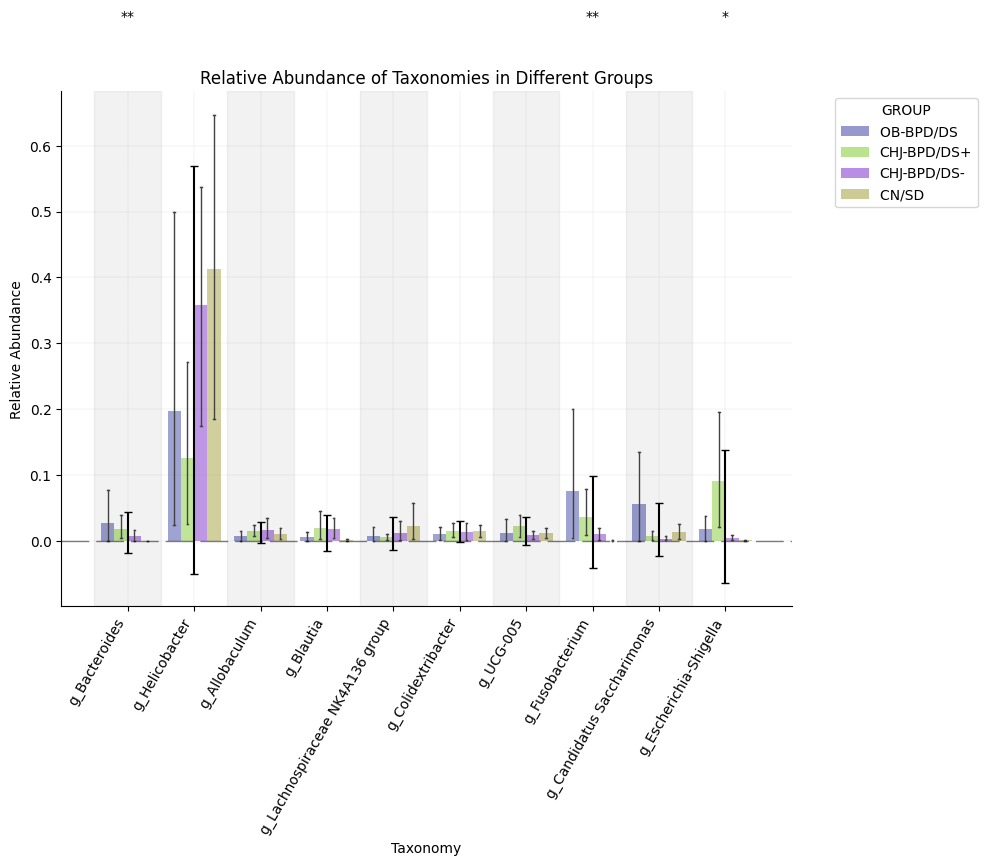

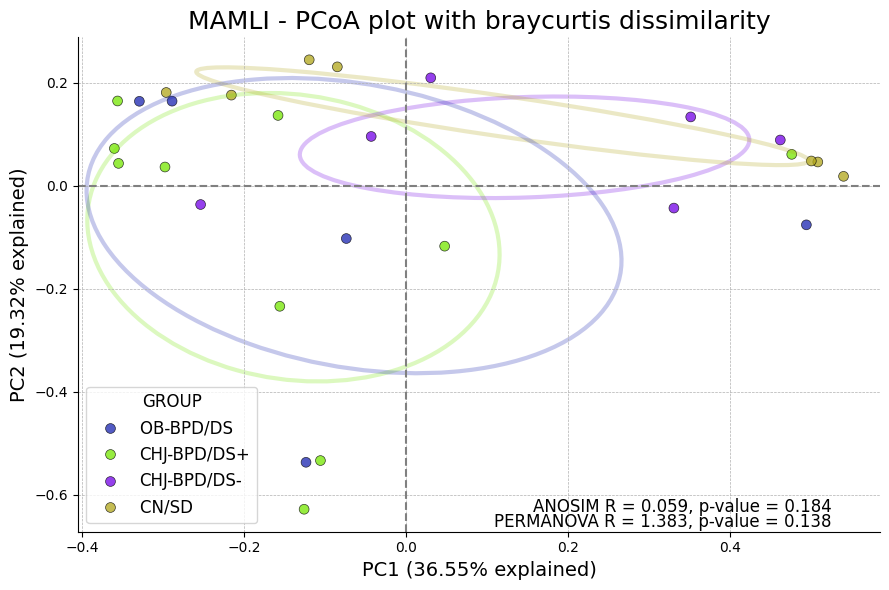

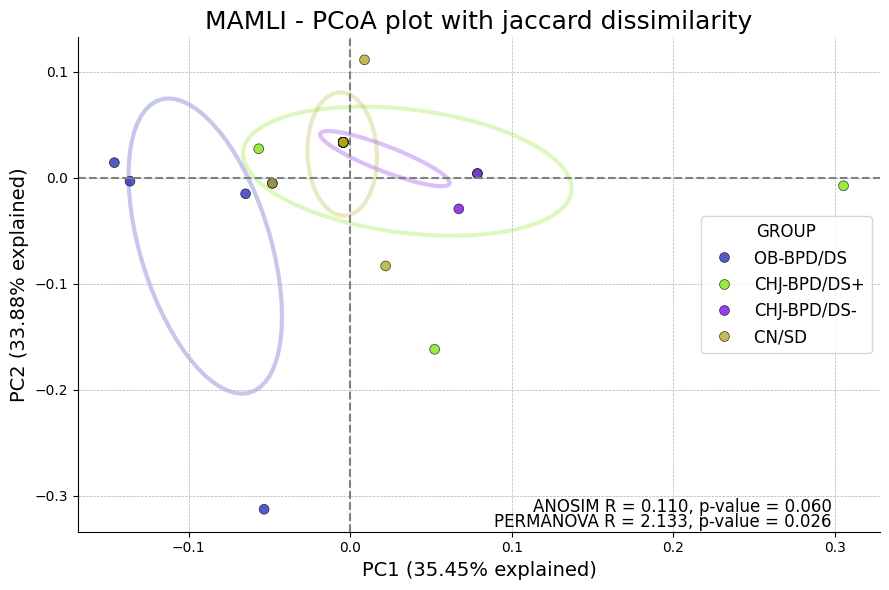

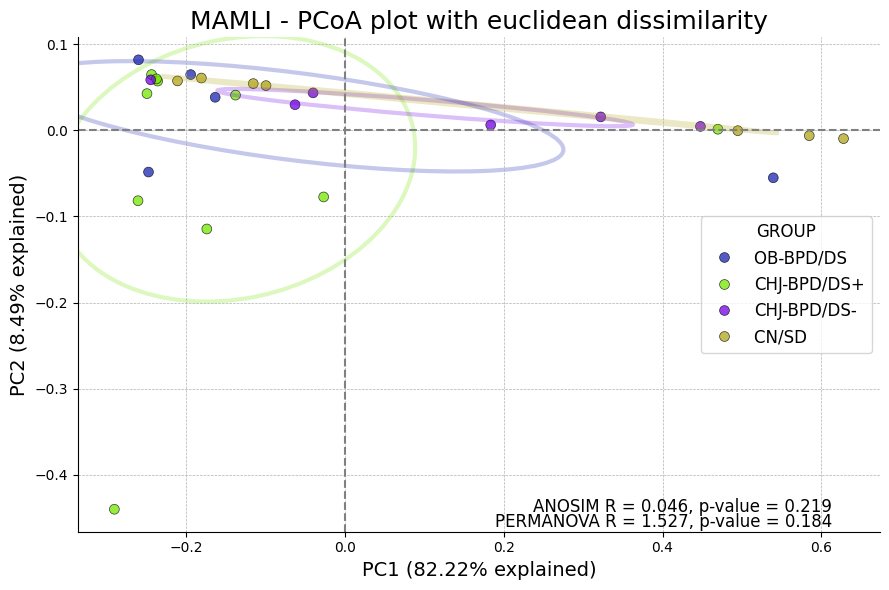

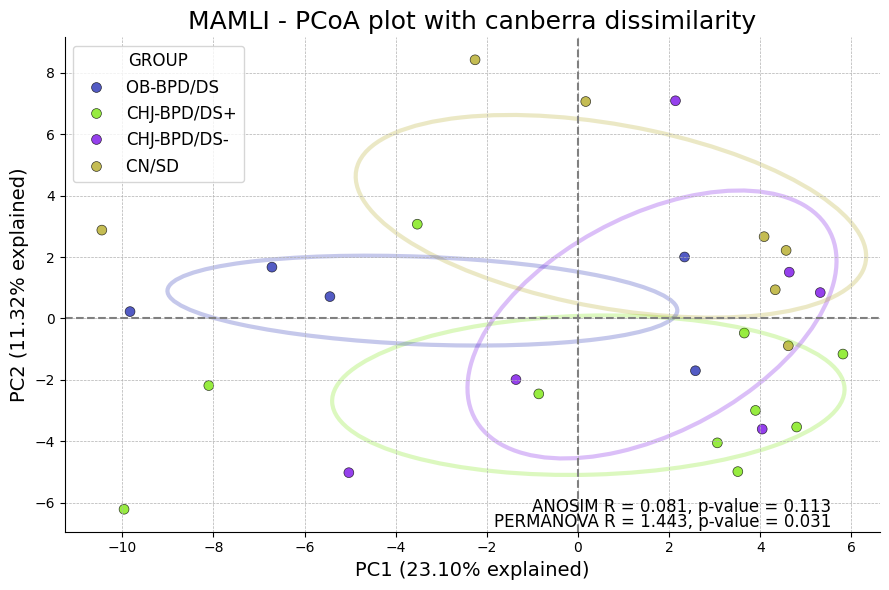

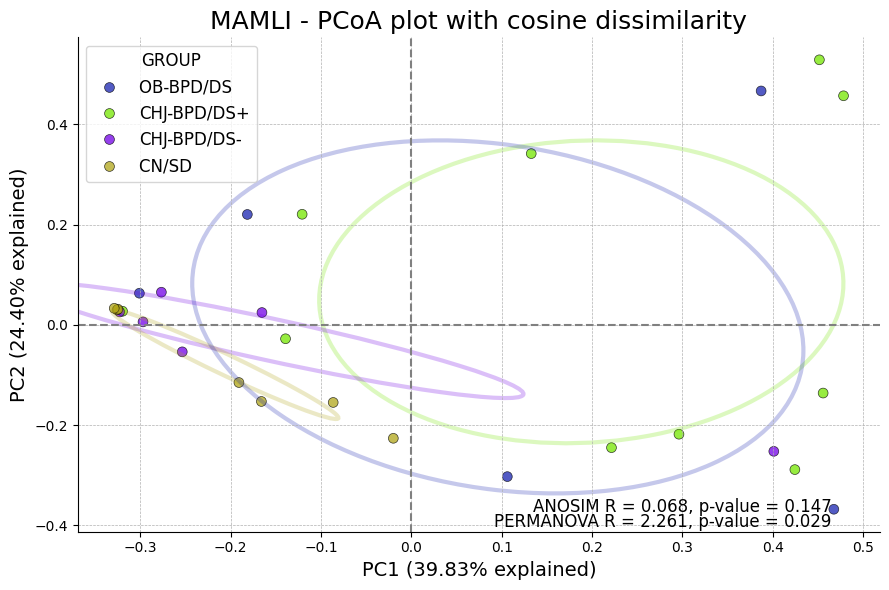


=== Analyzing Subgroup: MAM-D ===

=== SHANNON ANOVA ===
              sum_sq    df         F    PR(>F)
C(GROUP)   0.805561   3.0  0.594553  0.624924
Residual  10.387580  23.0       NaN       NaN
=== SHANNON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.4081  0.6619 -1.3883  0.5721   False
1  CHJ-BPD/DS+       CN/SD     0.0113  1.0000 -0.9259  0.9486   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.2296  0.9270 -1.2669  0.8077   False
3  CHJ-BPD/DS-       CN/SD     0.4194  0.6801 -0.6152  1.4541   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.1785  0.9711 -0.9476  1.3046   False


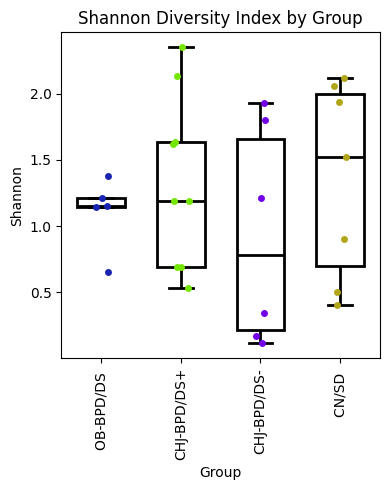


=== SIMPSON ANOVA ===
             sum_sq    df         F   PR(>F)
C(GROUP)  0.167620   3.0  0.723906  0.54804
Residual  1.775214  23.0       NaN      NaN
=== SIMPSON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.2076  0.5014 -0.6128  0.1976   False
1  CHJ-BPD/DS+       CN/SD    -0.0688  0.9602 -0.4563  0.3186   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.0255  0.9984 -0.4543  0.4034   False
3  CHJ-BPD/DS-       CN/SD     0.1388  0.8060 -0.2889  0.5665   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.1822  0.7032 -0.2834  0.6477   False


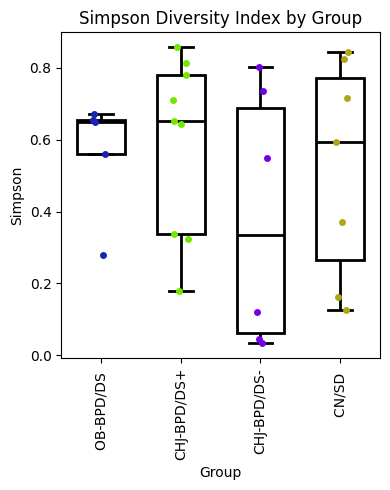


=== OBSERVED ANOVA ===
               sum_sq    df          F   PR(>F)
C(GROUP)  250.423280   3.0  12.076123  0.00006
Residual  158.984127  23.0        NaN      NaN
=== OBSERVED Tukey ===
         group1       group2  meandiff   p-adj    lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -1.1111  0.8528  -4.9457  2.7235   False
1  CHJ-BPD/DS+       CN/SD     1.2698  0.7739  -2.3967  4.9364   False
2  CHJ-BPD/DS+   OB-BPD/DS    -7.4444  0.0002 -11.5026 -3.3863    True
3  CHJ-BPD/DS-       CN/SD     2.3810  0.3835  -1.6668  6.4287   False
4  CHJ-BPD/DS-   OB-BPD/DS    -6.3333  0.0031 -10.7389 -1.9277    True


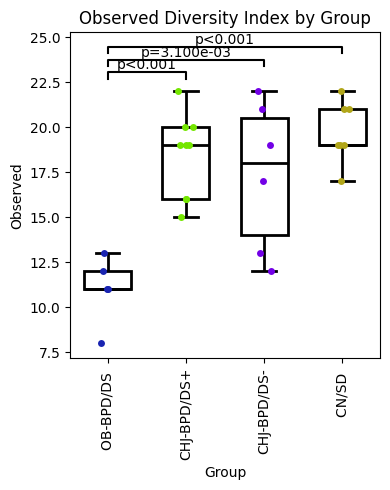


=== PIELOU_E ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.091499   3.0  0.577004  0.635959
Residual  1.215752  23.0       NaN       NaN
=== PIELOU_E Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.1420  0.6503 -0.4773  0.1934   False
1  CHJ-BPD/DS+       CN/SD    -0.0109  0.9997 -0.3315  0.3098   False
2  CHJ-BPD/DS+   OB-BPD/DS     0.0045  1.0000 -0.3503  0.3594   False
3  CHJ-BPD/DS-       CN/SD     0.1311  0.7368 -0.2229  0.4851   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.1465  0.7211 -0.2388  0.5317   False


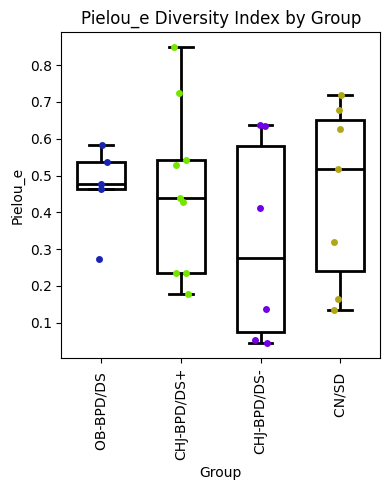

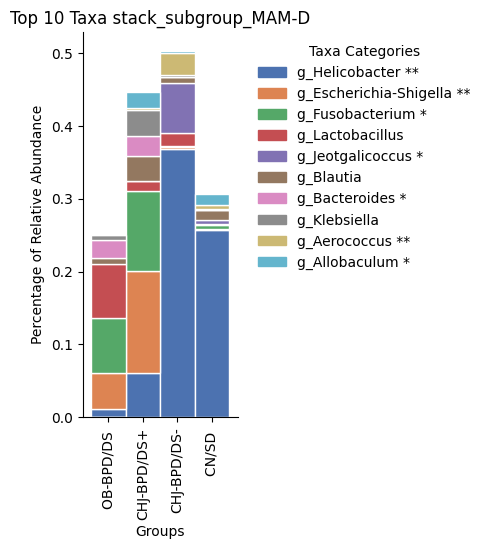

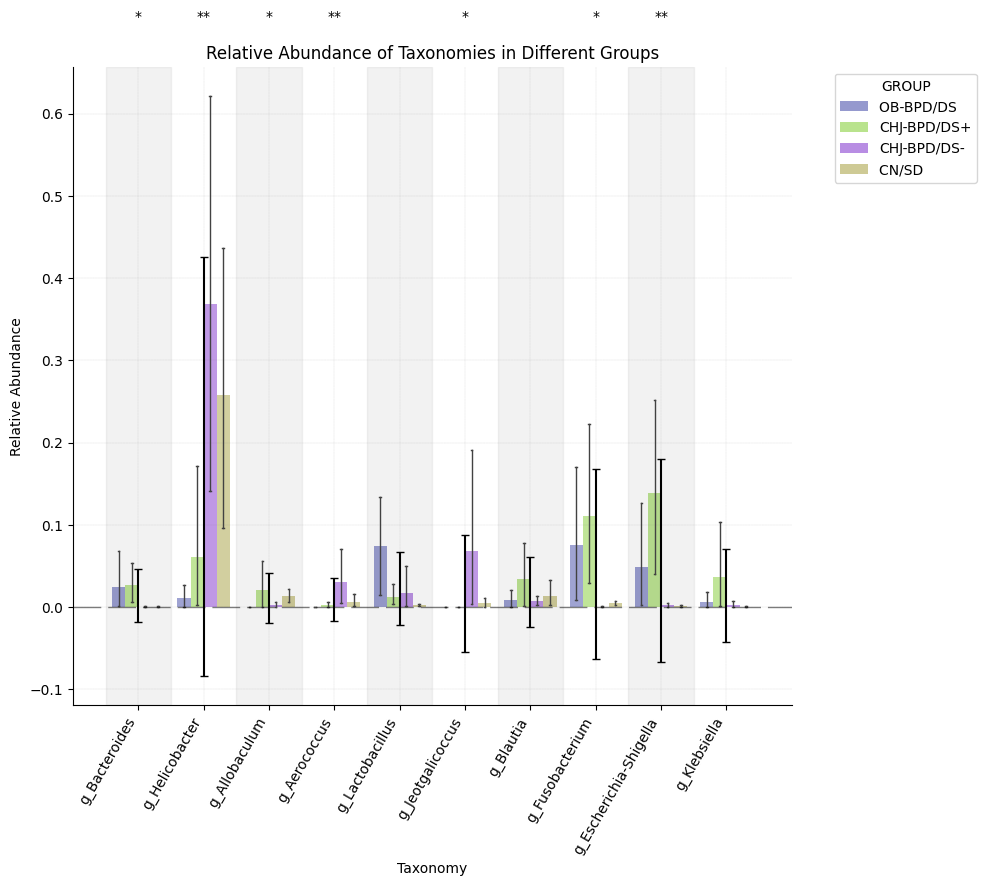

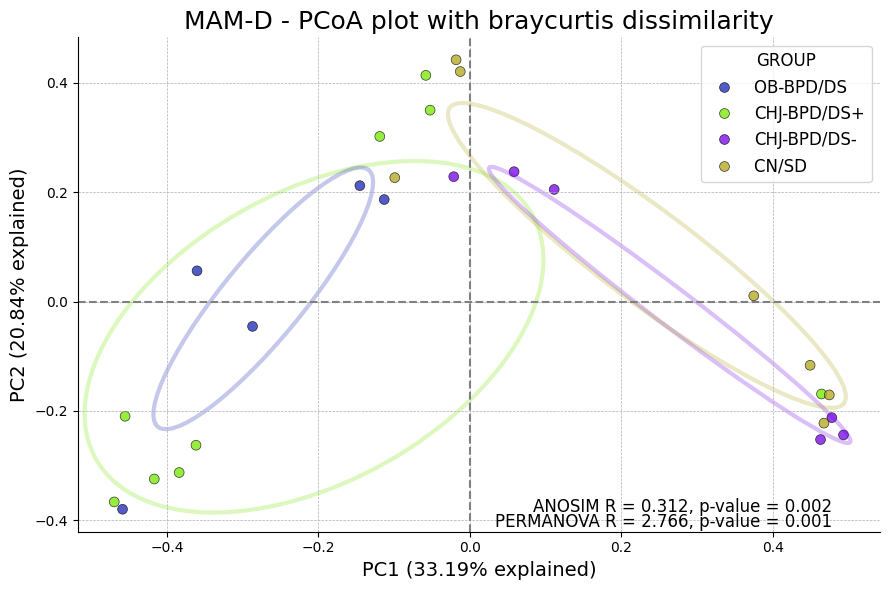

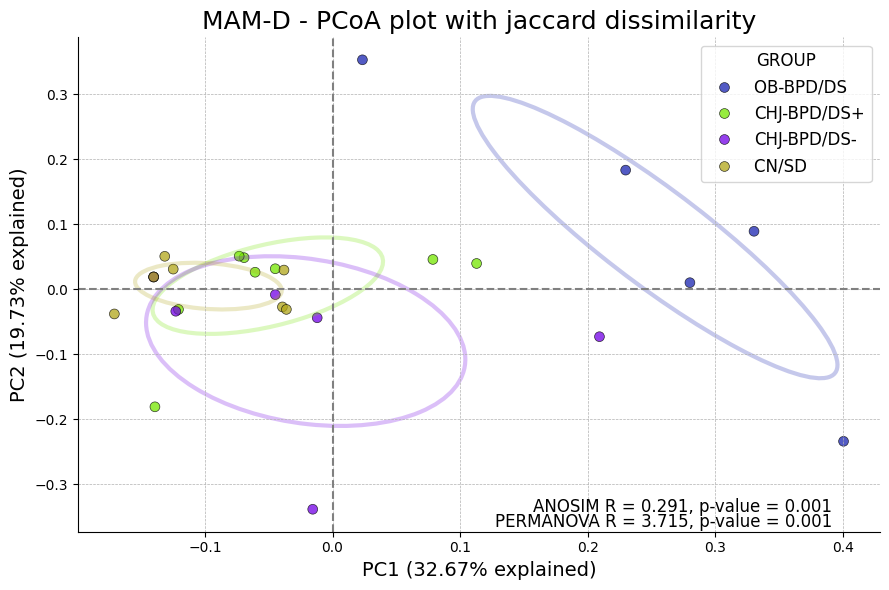

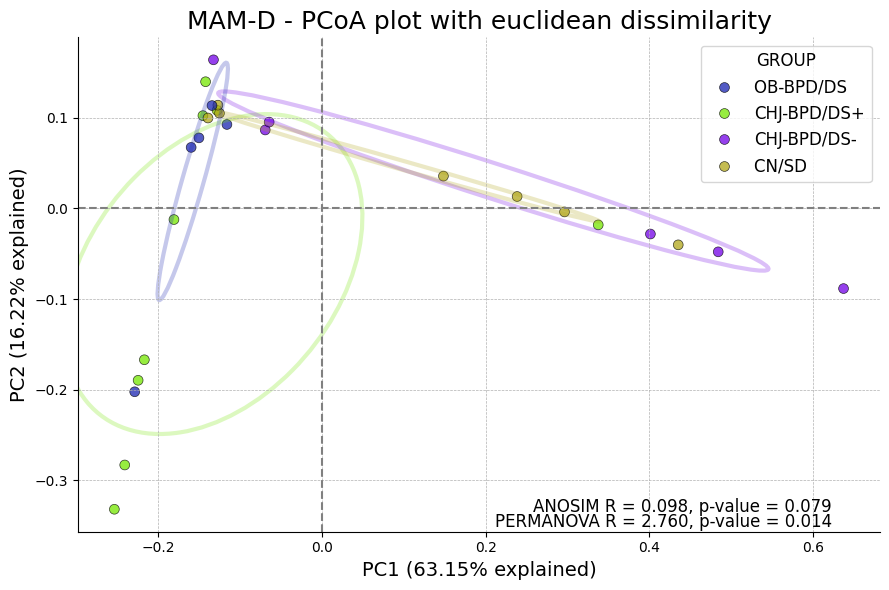

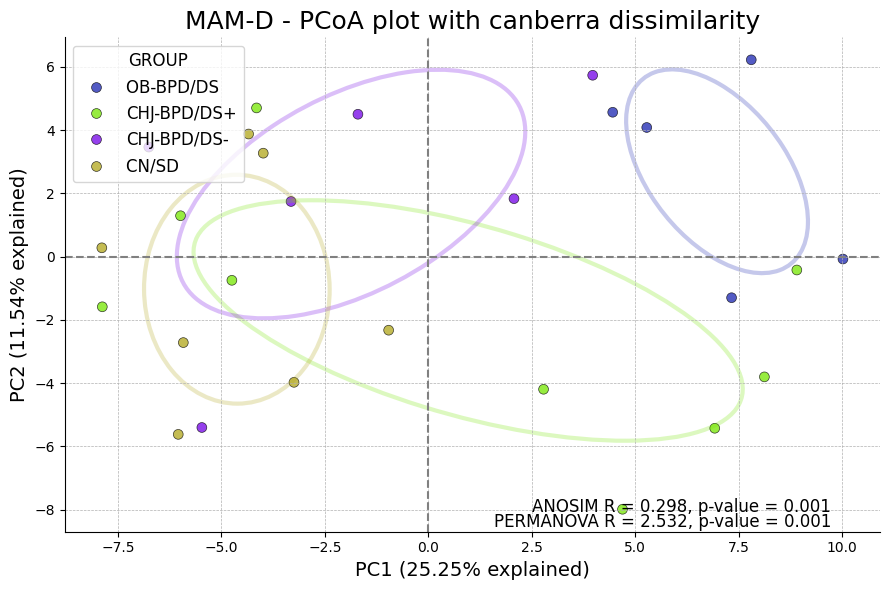

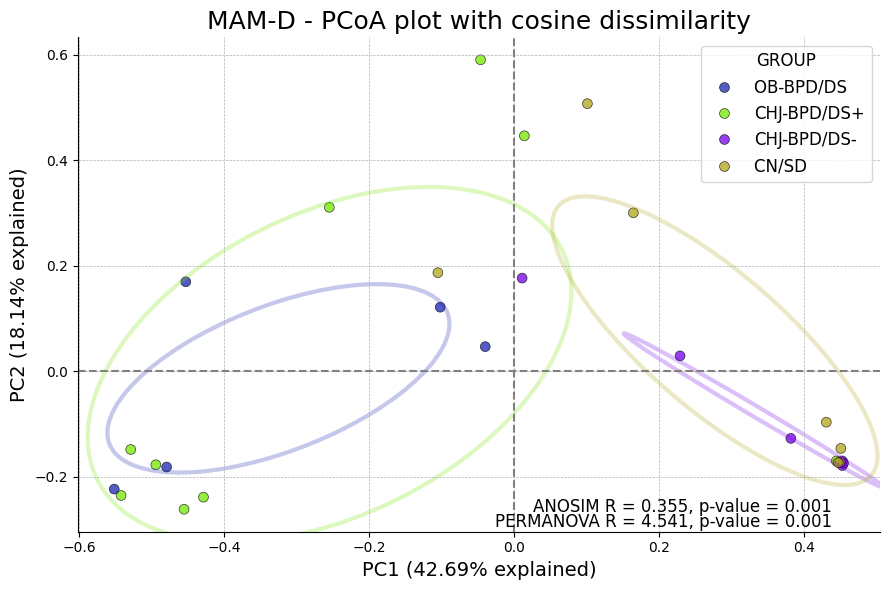


=== Analyzing Subgroup: Fecal ===

=== SHANNON ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.925289   3.0  1.497204  0.249137
Residual  3.708069  18.0       NaN       NaN
=== SHANNON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-    0.2276  0.7902 -0.4652  0.9204   False
1  CHJ-BPD/DS+       CN/SD    -0.0554  0.9971 -0.8409  0.7302   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.3906  0.5122 -1.1761  0.3950   False
3  CHJ-BPD/DS-       CN/SD    -0.2830  0.7702 -1.1110  0.5451   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.6182  0.1876 -1.4462  0.2099   False


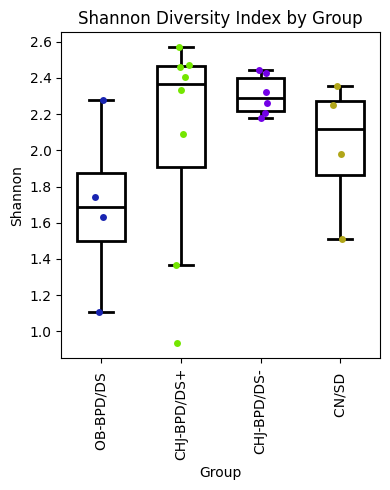


=== SIMPSON ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.069839   3.0  2.062052  0.141166
Residual  0.203213  18.0       NaN       NaN
=== SIMPSON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-    0.0632  0.6936 -0.0990  0.2253   False
1  CHJ-BPD/DS+       CN/SD     0.0071  0.9995 -0.1768  0.1910   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.1069  0.3809 -0.2908  0.0770   False
3  CHJ-BPD/DS-       CN/SD    -0.0561  0.8452 -0.2500  0.1377   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.1701  0.0975 -0.3639  0.0238   False


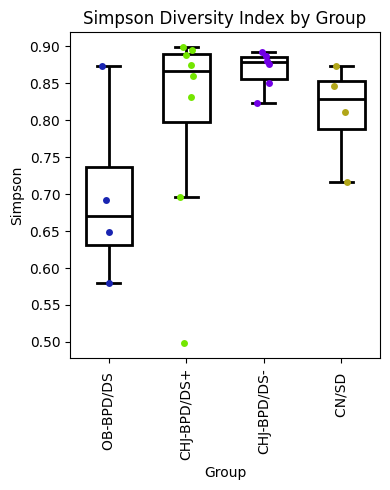


=== OBSERVED ANOVA ===
              sum_sq    df         F    PR(>F)
C(GROUP)  22.234848   3.0  3.972479  0.024611
Residual  33.583333  18.0       NaN       NaN
=== OBSERVED Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-    1.3333  0.3021 -0.7516  3.4182   False
1  CHJ-BPD/DS+       CN/SD     1.5000  0.3085 -0.8641  3.8641   False
2  CHJ-BPD/DS+   OB-BPD/DS    -1.2500  0.4611 -3.6141  1.1141   False
3  CHJ-BPD/DS-       CN/SD     0.1667  0.9975 -2.3253  2.6586   False
4  CHJ-BPD/DS-   OB-BPD/DS    -2.5833  0.0406 -5.0753 -0.0914    True


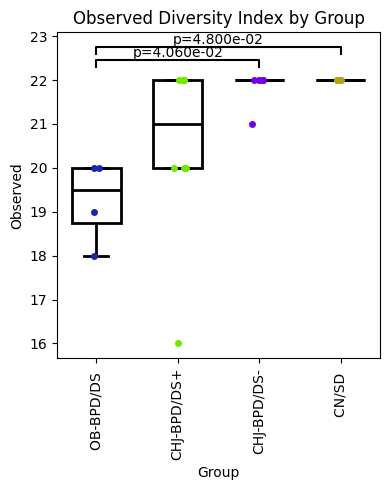


=== PIELOU_E ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.079104   3.0  1.310992  0.301563
Residual  0.362036  18.0       NaN       NaN
=== PIELOU_E Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-    0.0637  0.8390 -0.1528  0.2801   False
1  CHJ-BPD/DS+       CN/SD    -0.0298  0.9857 -0.2752  0.2157   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.1151  0.5593 -0.3606  0.1303   False
3  CHJ-BPD/DS-       CN/SD    -0.0935  0.7396 -0.3522  0.1653   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.1788  0.2420 -0.4375  0.0799   False


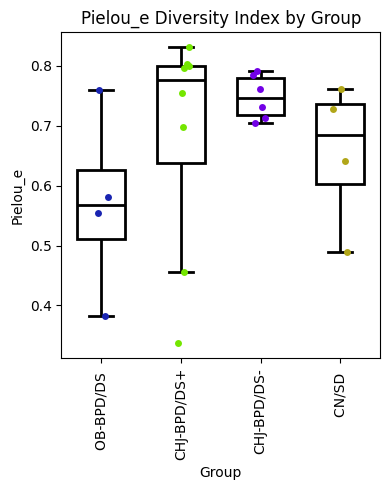

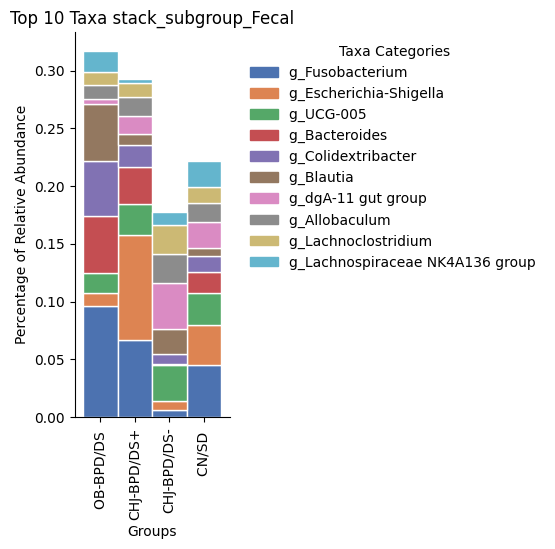

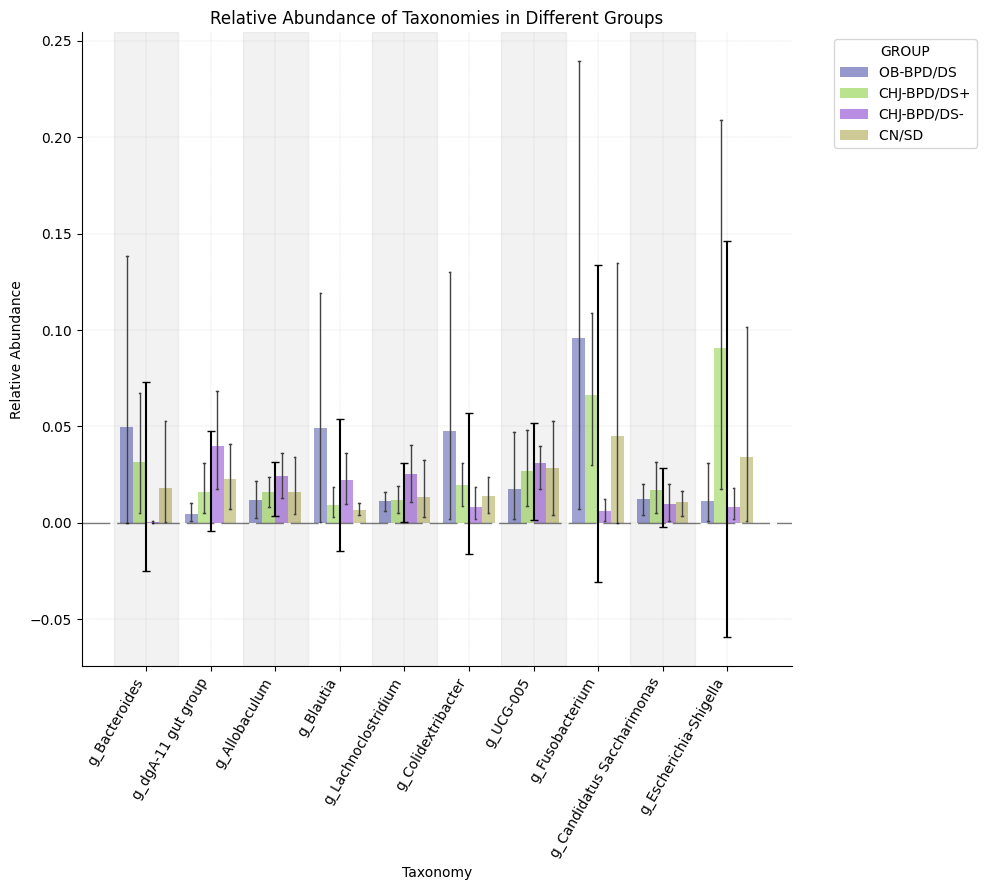

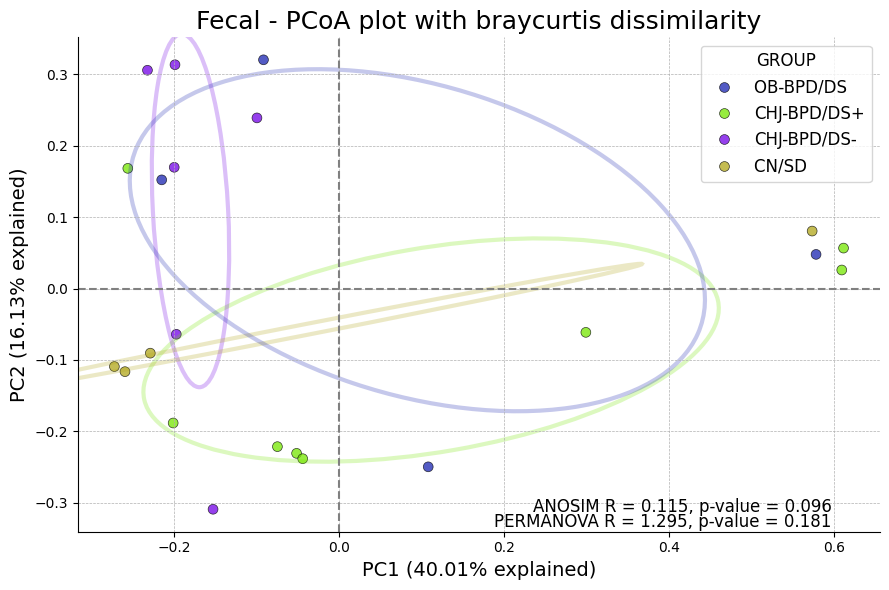

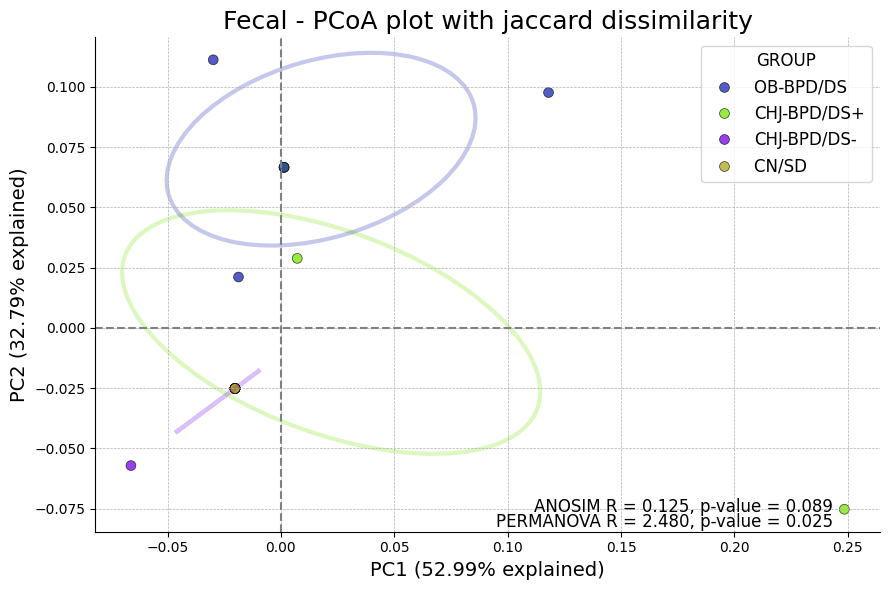

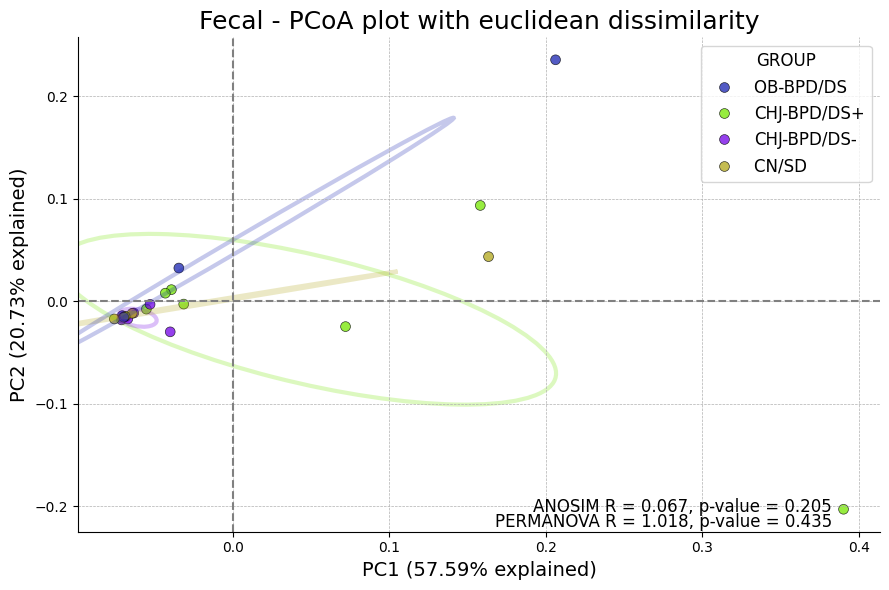

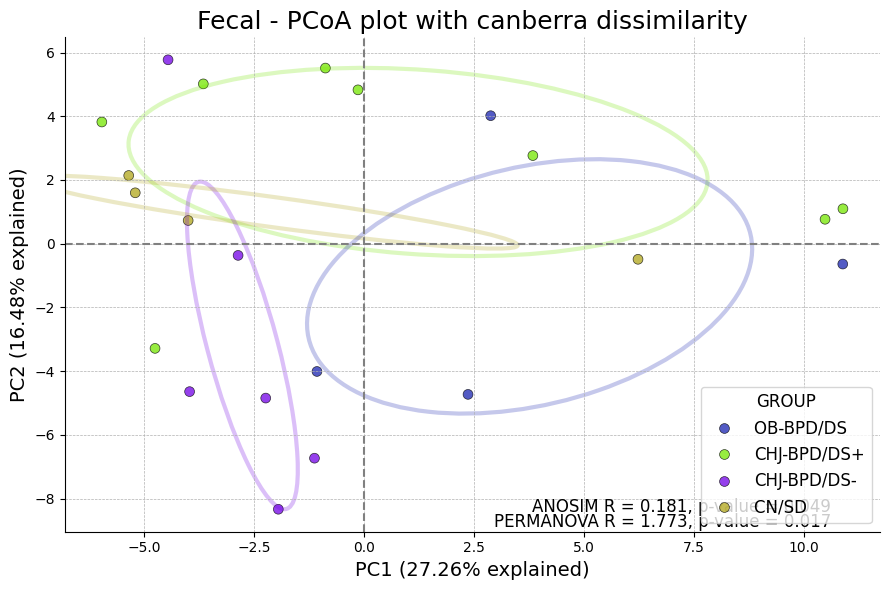

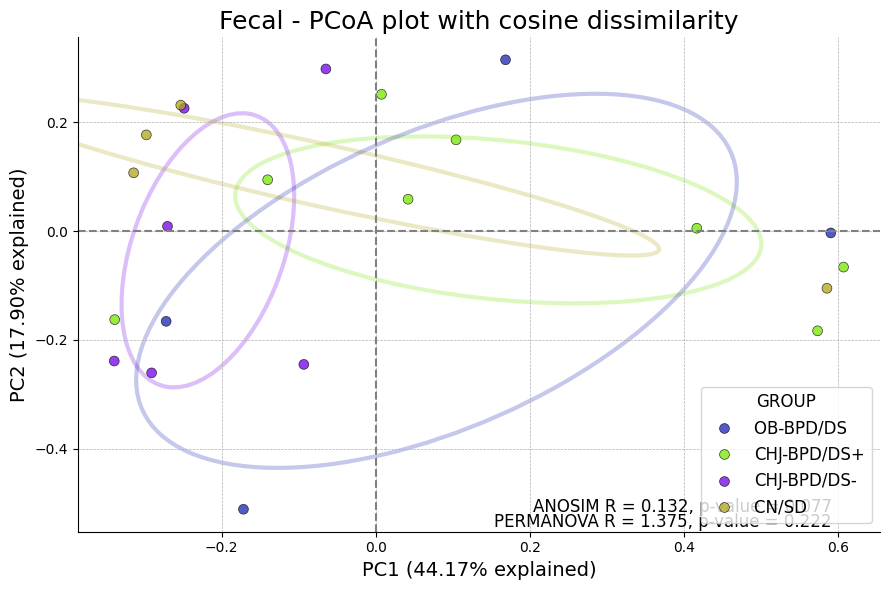

In [6]:
results_dict = msa.analyze_all_subgroups(df_filtered_genus, SUPGROUP_LIST, group_list=GROUP_LIST)


In [18]:
PART_OF_PATH = 'only_family_subgroup'
PATH_TO_ALPHA_OUTPUT_DATA = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/alpha/data'
PATH_TO_ALPHA_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/alpha/figure'
PATH_TO_BETA_OUTPUT_DATA = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/beta/data'
PATH_TO_BETA_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/beta/figure'
PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_DATA = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/relative_abundance/data'
PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/relative_abundance/figure'
PATH_TO_VENN_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/venn/figure'
PATH_TO_FB_OUTPUT_DATA = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/fb/data'
PATH_TO_FB_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/fb/figure'

SAFE_DATA = False
SHOW = False

#groups = DF['GROUP'].unique()
PALETTE = {GROUP_LIST[0]: '#1924B1', GROUP_LIST[1]: '#74E600', GROUP_LIST[2]:'#7200e6', GROUP_LIST[3]:'#b1a619'}
ma.PALETTE = PALETTE
ma.GROUP_LIST = GROUP_LIST

ma.PATH_TO_ALPHA_OUTPUT_DATA = PATH_TO_ALPHA_OUTPUT_DATA
ma.PATH_TO_ALPHA_OUTPUT_FIGURE = PATH_TO_ALPHA_OUTPUT_FIGURE
ma.PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_DATA  = PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_DATA
ma.PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_FIGURE = PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_FIGURE
ma.PATH_TO_VENN_OUTPUT_FIGURE = PATH_TO_VENN_OUTPUT_FIGURE
ma.PATH_TO_BETA_OUTPUT_DATA = PATH_TO_BETA_OUTPUT_DATA
ma.PATH_TO_BETA_OUTPUT_FIGURE = PATH_TO_BETA_OUTPUT_FIGURE
ma.PATH_TO_FB_OUTPUT_FIGURE = PATH_TO_FB_OUTPUT_FIGURE
ma.PATH_TO_FB_OUTPUT_DATA = PATH_TO_FB_OUTPUT_DATA
ma.SHOW = SHOW
ma.SAFE_DATA = SAFE_DATA

df_filtered_family = filter_taxa_by_level(df_filtered, taxonomy_col='Taxonomy', level='family')
print(df_filtered_family.shape)
df_filtered_family.head()

(2527, 7)


#SampleID              Taxonomy       GROUP Subgroup  Value  Total  \
58        10A  f_Corynebacteriaceae  OB-BPD/DS     MAM-J   1682  92085   
146       10A      f_Bacteroidaceae  OB-BPD/DS     MAM-J      2  92085   
158       10A      f_Muribaculaceae  OB-BPD/DS     MAM-J      0  92085   
165       10A      f_Prevotellaceae  OB-BPD/DS     MAM-J      0  92085   
177       10A       f_Rikenellaceae  OB-BPD/DS     MAM-J      0  92085   

     RelativeAbundance  
58            0.018266  
146           0.000022  
158           0.000000  
165           0.000000  
177           0.000000

In [19]:
results_dict = msa.analyze_all_subgroups(df_filtered_family, SUPGROUP_LIST, group_list=GROUP_LIST)


=== Analyzing Subgroup: MAM-J ===

=== SHANNON ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  1.341743   3.0  1.150416  0.348226
Residual  9.719261  25.0       NaN       NaN
=== SHANNON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-    0.3637  0.6424 -0.4815  1.2089   False
1  CHJ-BPD/DS+       CN/SD    -0.0707  0.9956 -0.9159  0.7745   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.2811  0.8431 -1.2204  0.6583   False
3  CHJ-BPD/DS-       CN/SD    -0.4345  0.5693 -1.3512  0.4823   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.6448  0.3126 -1.6490  0.3594   False

=== SIMPSON ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.217124   3.0  0.988182  0.414342
Residual  1.831007  25.0       NaN       NaN
=== SIMPSON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-    0.1363  0.7382 -0.2305  0.5032   False
1  CHJ-BPD/DS+       CN/SD    -0.0660  0.

In [20]:
PART_OF_PATH = 'only_phylum_subgroup'
PATH_TO_ALPHA_OUTPUT_DATA = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/alpha/data'
PATH_TO_ALPHA_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/alpha/figure'
PATH_TO_BETA_OUTPUT_DATA = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/beta/data'
PATH_TO_BETA_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/beta/figure'
PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_DATA = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/relative_abundance/data'
PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/relative_abundance/figure'
PATH_TO_VENN_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/venn/figure'
PATH_TO_FB_OUTPUT_DATA = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/fb/data'
PATH_TO_FB_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/fb/figure'

SAFE_DATA = True
SHOW = False

#groups = DF['GROUP'].unique()
PALETTE = {GROUP_LIST[0]: '#1924B1', GROUP_LIST[1]: '#74E600', GROUP_LIST[2]:'#7200e6', GROUP_LIST[3]:'#b1a619'}
ma.PALETTE = PALETTE
ma.GROUP_LIST = GROUP_LIST

ma.PATH_TO_ALPHA_OUTPUT_DATA = PATH_TO_ALPHA_OUTPUT_DATA
ma.PATH_TO_ALPHA_OUTPUT_FIGURE = PATH_TO_ALPHA_OUTPUT_FIGURE
ma.PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_DATA  = PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_DATA
ma.PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_FIGURE = PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_FIGURE
ma.PATH_TO_VENN_OUTPUT_FIGURE = PATH_TO_VENN_OUTPUT_FIGURE
ma.PATH_TO_BETA_OUTPUT_DATA = PATH_TO_BETA_OUTPUT_DATA
ma.PATH_TO_BETA_OUTPUT_FIGURE = PATH_TO_BETA_OUTPUT_FIGURE
ma.PATH_TO_FB_OUTPUT_FIGURE = PATH_TO_FB_OUTPUT_FIGURE
ma.PATH_TO_FB_OUTPUT_DATA = PATH_TO_FB_OUTPUT_DATA
ma.SHOW = SHOW
ma.SAFE_DATA = SAFE_DATA

df_filtered_phylum = filter_taxa_by_level(df_filtered, taxonomy_col='Taxonomy', level='phylum')
print(df_filtered_phylum.shape)
df_filtered_phylum.head()

(931, 7)


#SampleID            Taxonomy       GROUP Subgroup  Value  Total  \
58        10A  p_Actinobacteriota  OB-BPD/DS     MAM-J   1682  92085   
142       10A      p_Bacteroidota  OB-BPD/DS     MAM-J      4  92085   
218       10A  p_Campylobacterota  OB-BPD/DS     MAM-J     15  92085   
279       10A        p_Firmicutes  OB-BPD/DS     MAM-J      2  92085   
552       10A    p_Fusobacteriota  OB-BPD/DS     MAM-J      0  92085   

     RelativeAbundance  
58            0.018266  
142           0.000043  
218           0.000163  
279           0.000022  
552           0.000000

In [21]:
results_dict = msa.analyze_all_subgroups(df_filtered_phylum, SUPGROUP_LIST, group_list=GROUP_LIST)


=== Analyzing Subgroup: MAM-J ===

=== SHANNON ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  1.744709   3.0  5.051969  0.007144
Residual  2.877935  25.0       NaN       NaN
=== SHANNON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-    0.0942  0.9420 -0.3658  0.5541   False
1  CHJ-BPD/DS+       CN/SD    -0.3148  0.2608 -0.7747  0.1452   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.5772  0.0227 -1.0884 -0.0661    True
3  CHJ-BPD/DS-       CN/SD    -0.4089  0.1362 -0.9078  0.0899   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.6714  0.0120 -1.2179 -0.1249    True

=== SIMPSON ANOVA ===
             sum_sq    df       F   PR(>F)
C(GROUP)  0.482157   3.0  5.2999  0.00575
Residual  0.758122  25.0     NaN      NaN
=== SIMPSON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-    0.0474  0.9451 -0.1887  0.2834   False
1  CHJ-BPD/DS+       CN/SD    -0.1796  0.1828 -0.4

In [7]:
df_kruskal = results_dict['MAM-J'][3]  # берем 4-й элемент кортежа
df_significant = df_kruskal[df_kruskal['p_value_fdr'] < 0.05]
print(df_significant)


            Taxonomy  p_value_raw  p_value_fdr
17      g_Romboutsia     0.000572     0.012580
7       g_Aerococcus     0.001764     0.012934
9   g_Jeotgalicoccus     0.001286     0.012934


In [13]:
results_dict

{'MAM-J': (   SampleID        GROUP   shannon   simpson  observed  pielou_e
  0       10A   OB-BPD/DS   0.872151  0.424282        12  0.350979
  1       11A  CHJ-BPD/DS+  0.156571  0.041197        21  0.051427
  2       12A  CHJ-BPD/DS+  0.592252  0.301806        16  0.213610
  3       13A  CHJ-BPD/DS+  2.327704  0.877995        22  0.753048
  4       14A  CHJ-BPD/DS+  0.772121  0.392900        17  0.272525
  5       15A  CHJ-BPD/DS+  1.420330  0.718662        14  0.538196
  6       16A  CHJ-BPD/DS+  0.621627  0.243741        19  0.211119
  7       18A  CHJ-BPD/DS+  0.943875  0.456596        18  0.326559
  8       19A  CHJ-BPD/DS+  1.806780  0.773615        19  0.613625
  9       20A  CHJ-BPD/DS+  1.120930  0.575007        19  0.380694
  10      21A  CHJ-BPD/DS+  1.434973  0.628974        22  0.464236
  11      22A  CHJ-BPD/DS-  2.233066  0.847672        21  0.733470
  12      23A  CHJ-BPD/DS-  0.188864  0.056891        16  0.068118
  13     24A1  CHJ-BPD/DS-  2.113303  0.838418       